# Investigation of How Features Project Onto Attention Parameters

## Overview

The autoencoders generated within this repository consist of a number of vectors ("features") in the residual space, each representing a (hopefully interpretable) feature of residual space. Here, we want to look at the attention heads of the model through the lens of those features.

Our intention is to explore the alignment between features and attention parameters. At a high level, the motivation is that for each attention parameter (`Q`, `K`, `V`), and for each feature, we want to know how closely that attention parameter is aligned with that feature. One approach to achieve this quantitatively is by employing the cosine similarity (or its squared counterpart, depending on the exact nature of our interpretability objectives).

If we were doing this for a feature ($ \in \mathbb{R}^d\_model $) and a neuron ($ \in \mathbb{R}^d\_model $), we could do this by measuring the cosine similarity
$ cos\_sim(\mathbf{a}, \mathbf{b}) = \frac{\mathbf{a} \cdot \mathbf{b}}{\| \mathbf{a} \| \| \mathbf{b} \|} $
if we were measuring the extent to which the feature aligned with the neuron, or the squared cosine similarity
$ cos^2\_sim(\mathbf{a}, \mathbf{b}) = cos\_sim(\mathbf{a}, \mathbf{b})^2 $
if we only cared about the extent to which they were non-orthogonal.

We would like to do the analogous operation, where we have a column vector 
$ \mathbf{f} \in \mathbb{R}^n $
(our dictionary feature) and a subspace
$ A \in \mathbb{R}^{n \times m} $ (our attention paremteter). We only care about magnitude, rather than direction, since an attention space does not meaningfully have a direction (I think, **@todo** confirm this with someone who knows math). That operation looks like

However, what we actually have here is a matrix
$ F \in \mathbb{R}^{d\_dict \times d\_model} $
which represents d\_dict features each of size 
$ d_{\text{model}} = d\_model $
from our learned dictionary, and an attention parameter matrix 
$ W \in \mathbb{R}^{d\_model \times d\_attn} $
an attention parameter (e.g. the key matrix of layer 1 head 3).

Our analogous operation, then, looks like

1. Normalize the columns of $ W $ to unit norm:  
$ {{W\_normed}_{ij}} = \frac{W_{ij}}{\sqrt{\sum_{i=1}^{d\_model} W_{ij}^2}} $  
where $ i $ denotes the row index and $ j $ the column index.

3. Compute a matrix product between the attention parameter matrix and the normalized matrix of dictionary features $ \text{F} $, element-wise squared:  
$ M = (W\_normed \cdot F)^2 $  
where $ \cdot $ denotes matrix multiplication.

5. Sum over the columns of matrix $ M $ to get a resulting vector $ \text{result} \in \mathbb{R}^{d\_dict} $:  
$ \text{result}_i = \sum_{j=1}^{d\_model} M_{ij} $

We call this score the **Feature-Attention Alignment Score** (FAAS) (**@todo** better name for this, also is this basically a standard metric already? This has _got_ to be some sort of standard metric). Note that FAAS can exceed 1.

## Hypotheses

1. For features the attention head does not "care" about, the FAAS values will cluster near 0. If you pass a dictionary of random features to this method, it will form a normal distribution centered around $ \frac{d\_attn}{d\_model} $ because math.
2. For a dictionary trained on the residual stream of the same model the attention heads are from, FAAS will form a long-tailed or bimodal distribution, with a large cluster of features with near-zero FAAS, and a few features with large FAAS.
3. The features with large FAAS values will be semantically related to each other when the technique is applied to language models.

## Code

In [1]:
!pip install transformer_lens 
!pip install torch
!pip install numpy
!pip install matplotlib
!pip install einops
!pip install dataclasses
!pip install datasets
!pip install IPython
!pip install circuitsvis



In [2]:
!pip install torchopt
!pip install sklearn

### Notebook setup stuff

This notebook lives in the `./interp_notebooks/` directory, which is not the same as the project root. We need to add the project root directory (`..`) to the path so that importing stuff works

In [3]:
import sys
import os
sys.path.insert(0, os.path.realpath('..'))

### Imports

Third-party libraries

In [4]:
from transformer_lens import HookedTransformer
import torch
import numpy as np
import matplotlib.pyplot as plt
import einops
from dataclasses import dataclass
from datasets import Dataset, load_dataset
from IPython.display import display, Markdown
from circuitsvis.activations import text_neuron_activations
from circuitsvis.tokens import colored_tokens
from matplotlib.animation import FuncAnimation


Stuff specific to this repo

In [5]:
from notebook_utils import (
    hyperparams_match,
    load_autoencoders,
    get_dictionary_activations,
    get_tokens_and_activations,
    get_feature_datapoints,
    get_neuron_activation,
    ablate_text,
    visualize_text,
    ablate_feature_direction,
    visualize_logit_diff
)

### Helper functions

In [6]:
def feature_attention_alignment_scores(features, attn_param):
    # features.shape == (d_dict, d_model)
    # so axis 1 is d_model
    normed_features   = features / torch.linalg.norm(features, axis=1, keepdim=True)
    # attn_param.shape == (d_model, d_attn)
    # so axis 0 is d_model
    normed_attn_param = attn_param / torch.linalg.norm(attn_param, axis=0, keepdim=True)
    cos_sims = torch.einsum(
        'an, nb -> ab',
        normed_features,
        normed_attn_param
    )
    scores = (cos_sims**2).sum(axis=1)
    return scores
    


def feature_transformation_by_head(features,attn_param):

    #normed_features   = features / torch.linalg.norm(features, axis=1, keepdim=True)
    #normed_attn_param = attn_param / torch.linalg.norm(attn_param, axis=1, keepdim=True)
    # Create a linear transformation matrix
    transformed_features = torch.einsum(
        'an, nb -> ab',
        features,
        attn_param
    )
    return transformed_features

### Setup

#### Configuration

In [7]:
model_name = 'EleutherAI/Pythia-70m-deduped'
dataset_name = "NeelNanda/pile-10k"
token_amount=25
device = 'cuda'

#### Load the model (from HF or cache)

In [8]:
model = HookedTransformer.from_pretrained(model_name, device=device)

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/Pythia-70m-deduped into HookedTransformer


#### Load the autoencoder from disk

In [9]:
hyperparams_by_path = {
    f'outputs/{model.lower().replace("/", "--")}/sweep_residual/chunks/{chunk:02d}/layer_{layer:d}/dict_ratio_{dict_ratio:d}/learned_dicts.pt': {
        "chunk": chunk,
        "layer": layer,
        "cache_name": f"blocks.{layer}.hook_resid_post",
        "dict_ratio": dict_ratio,
        "model": model,
    }
    for model, chunks in [
        ("EleutherAI/Pythia-70m-deduped", [0, 5, 10, 15, 20, 25, 29]),
        ("roneneldan/TinyStories-33m",    [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 49]),
    ]
    for chunk in chunks
    for layer in [0, 1, 2, 3, 4, 5]
    for dict_ratio in [1, 2, 4, 8]
}

desired_hyperparams = {
    "model": lambda model: model == "EleutherAI/Pythia-70m-deduped",
    "chunk": lambda chunk: chunk == 10,
    "layer": lambda layer: layer == 2,
    "dict_ratio": lambda dict_ratio: dict_ratio in [2],
    "l1_alpha": lambda l1_alpha: abs(l1_alpha - 0.002) < 1e-6,
}

In [10]:
located_autoencoders = load_autoencoders(desired_hyperparams,hyperparams_by_path)

autoencoder = located_autoencoders[0].autoencoder
autoencoder.to_device(device)
learned_dict = autoencoder.get_learned_dict()
cache_name = located_autoencoders[0].hyperparams['cache_name']
print("Here is the first feature")
print(learned_dict[0])

Here is the first feature
tensor([-5.6310e-03, -3.3202e-02, -9.6583e-03,  5.4427e-02, -5.4795e-02,
         6.5799e-02, -1.6796e-02, -7.9475e-04, -7.3396e-02,  2.4690e-02,
        -3.1550e-02,  9.2962e-02, -4.8443e-02,  5.1900e-02, -9.9166e-03,
        -1.5936e-02, -3.1179e-02,  2.6412e-02,  7.5457e-02,  1.8491e-02,
        -4.1156e-02, -9.3501e-03, -1.6938e-02, -9.5360e-02, -2.7275e-02,
        -6.7445e-02, -3.9722e-03,  3.6336e-02, -2.1960e-03,  1.1202e-03,
         2.7792e-02, -3.8507e-02, -4.4557e-02,  3.3584e-03, -1.9618e-02,
         4.5644e-04, -5.0996e-02, -1.8884e-02, -1.5286e-02, -5.7225e-02,
        -1.4876e-02, -1.3129e-02,  4.3383e-02, -9.1134e-03,  3.4010e-03,
        -8.2100e-02, -2.4933e-02, -5.0832e-03,  1.4151e-01, -1.4162e-02,
        -2.8902e-02,  1.3329e-02,  2.8712e-03, -6.1419e-02, -2.6935e-02,
         3.5120e-02, -1.4668e-02,  4.3477e-02,  7.5498e-04, -8.1790e-03,
        -3.2856e-02, -8.3711e-04,  9.7525e-04, -4.2273e-02, -4.2812e-02,
         5.7420e-02,  1.2

In [11]:
attn = {
    'q': [dict(model.named_parameters())[f'blocks.{i}.attn.W_Q'] for i in range(6)],
    'k': [dict(model.named_parameters())[f'blocks.{i}.attn.W_K'] for i in range(6)],
    'v': [dict(model.named_parameters())[f'blocks.{i}.attn.W_V'] for i in range(6)],
    'o': [dict(model.named_parameters())[f'blocks.{i}.attn.W_O'] for i in range(6)],
}
embedding = model.W_E


#### Load the input data we'll compute activations for

In [12]:
dataset = load_dataset(dataset_name, split="train").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)

#### And actually compute the activations

In [13]:
dictionary_activations = get_dictionary_activations(model, autoencoder, dataset, cache_name, token_amount, device, 256)

W_OV is a transformation from residual stream to residual stream
Let W_OVf be the transformed feature where f is a dictionary feature
Given f_i, we compute the set of f_j (denoted C_i) such that cos_sim(W_OVf_i, f_j) is greater than (1- epsilon)
We see that C_i tends to be a singleton consisting of f_i only for low enough values of epsilon

In [64]:
#here plotting the deformation of features by attention_heads
#We fix one head - head[4][5]
features = learned_dict

def cos_sim(a,b):
    norm = torch.norm(a) * torch.norm(b)
    return (torch.dot(a,b)/norm).detach().cpu()

num_features =features.size(-2)
W_OV = torch.einsum(
        'na, bn -> ab',
        attn['o'][3][2],
        attn['v'][3][2]
    )

print(W_OV.shape)
transformed_features = feature_transformation_by_head(
    learned_dict,
    W_OV
)

set_of_relations = []
#play with epsilon to shorlist the features that have higher cosine similarity with the original features
epsilon = 0.3

for i in range(num_features):
    row = []
    for j in range(num_features):
        cossim = cos_sim(transformed_features[i],features[j])
        if cossim > epsilon:
            row.append((cossim,j))
    if row:
        set_of_relations.append((i,row))
    
print(set_of_relations)      

feature_ids = []
for index,_ in set_of_relations:
    feature_ids.append(index)



torch.Size([512, 512])
[(1, [(tensor(0.3270), 637)]), (10, [(tensor(0.3174), 466)]), (156, [(tensor(0.3033), 334)]), (158, [(tensor(0.3460), 665)]), (305, [(tensor(0.3088), 637)]), (313, [(tensor(0.3157), 637)]), (406, [(tensor(0.3488), 637)]), (495, [(tensor(0.3218), 637)]), (556, [(tensor(0.3115), 637)]), (637, [(tensor(0.5761), 637)]), (662, [(tensor(0.3137), 662)]), (665, [(tensor(0.3788), 665)]), (846, [(tensor(0.3135), 637)]), (881, [(tensor(0.3142), 466)]), (897, [(tensor(0.3083), 466)]), (997, [(tensor(0.3019), 997)])]


Observation:
The highest cosine similarity between transformed features and the original features is observed towards the same features, that is, a transformed feature tends to have a higher cosine similarity with itself rather than other features in the residual stream

Is it possible that the heads is just doing a compressional algorithm on the features such that they can be easily recovered?

Let's obeserve ||W_OVf_i -f_i||^2 where i is in the range of dictionary size!

#### Random dictionary, random attention param

In [16]:
'''distance= []
for i in range(num_features):
    distance.append(torch.norm(transformed_features[i]-features[i]).detach().cpu())
print(distance)
'''

'distance= []\nfor i in range(num_features):\n    distance.append(torch.norm(transformed_features[i]-features[i]).detach().cpu())\nprint(distance)\n'

High enough distance between feature and transformed feature, so the optimisation problem is not minimising the euclidean distance, doubt is that it is minimising the cosine similarity instead

Can we watch the features when they are in the embedding space? Does a left inverse of the embedding matrix makes sense
left_inverse = torch.linalg.pinv(matrix)

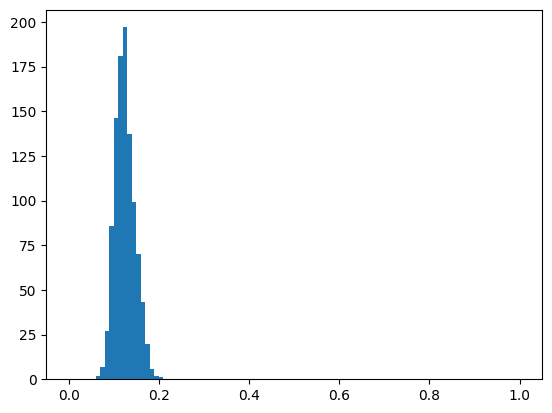

In [17]:
scores = feature_attention_alignment_scores(
    torch.randn(1024, 512).cuda(),
    torch.randn(512, 64).cuda()
).detach().cpu()
plt.hist(scores, bins=100, range=(0, 1))
plt.show()

Indeed, this does show a normal-ish looking distribution centered on $ \frac{d\_attn}{d\_model} = \frac{64}{512} = 0.125 $

#### Random dictionary, real attention param (layer 4, head 5)

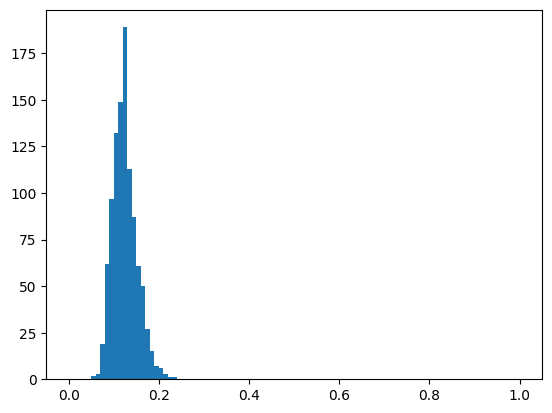

In [18]:
scores = feature_attention_alignment_scores(
    torch.randn(1024, 512).cuda(),
    attn['k'][4][5]
).detach().cpu()
plt.hist(scores, bins=100, range=(0, 1))
plt.show()

Again, normal-ish distribution centered around $ \frac{d\_attn}{d\_model} = \frac{64}{512} = 0.125 $

#### Real dictionary, random attention pattern

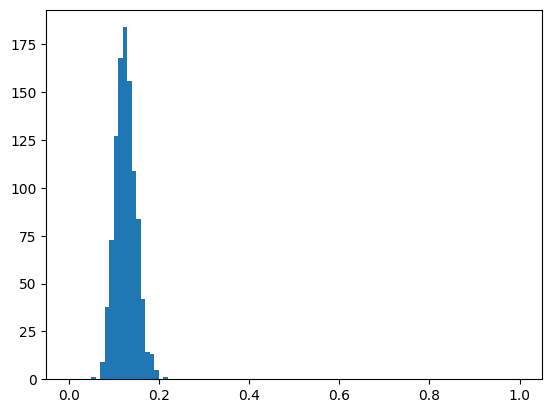

In [19]:
scores = feature_attention_alignment_scores(
    learned_dict,
    torch.randn(512, 64).cuda()
).detach().cpu()
plt.hist(scores, bins=100, range=(0, 1))
plt.show()

Again, normal-ish distribution centered around $ \frac{d\_attn}{d\_model} = \frac{64}{512} = 0.125 $

### Testing on real features and attention params

##### Verify that the FAAS distribution is long-tailed on an attn key param

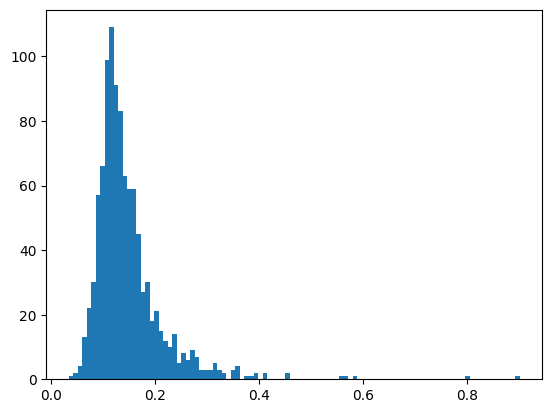

In [20]:
layer, head = 4, 5

scores = feature_attention_alignment_scores(learned_dict, attn['k'][layer][head]).detach().cpu()
plt.hist(scores, bins=100)
plt.show()

That is the long-tailed distribution we've been looking for.

##### Verify that the FAAS distribution is long-tailed on an attn query param

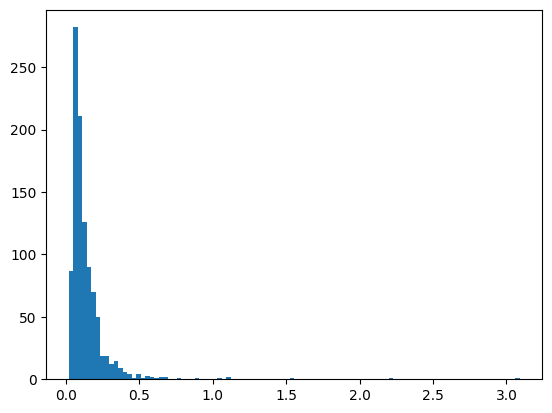

In [21]:
layer, head = 4, 3

scores = feature_attention_alignment_scores(learned_dict, attn['q'][layer][head]).detach().cpu()
plt.hist(scores, bins=100)
plt.show()

That is _very much_ the long-tailed distribution we've been looking for.

In [22]:
print(feature_ids)
print(set_of_relations)

[8, 17, 66, 114, 144, 167, 177, 245, 295, 333, 346, 359, 364, 369, 397, 454, 510, 535, 537, 551, 637, 662, 665, 669, 758, 823, 837, 847, 883, 901, 904, 997]
[(8, [(tensor(0.2522), 8)]), (17, [(tensor(0.3021), 17)]), (66, [(tensor(0.3795), 66)]), (114, [(tensor(0.2646), 114)]), (144, [(tensor(0.3294), 144)]), (167, [(tensor(0.3141), 167)]), (177, [(tensor(0.3665), 177)]), (245, [(tensor(0.2666), 245)]), (295, [(tensor(0.3142), 295)]), (333, [(tensor(0.2510), 837)]), (346, [(tensor(0.5159), 346)]), (359, [(tensor(0.3821), 359)]), (364, [(tensor(0.2567), 637)]), (369, [(tensor(0.2537), 637)]), (397, [(tensor(0.3104), 397)]), (454, [(tensor(0.2558), 454)]), (510, [(tensor(0.2504), 1006)]), (535, [(tensor(0.3561), 535)]), (537, [(tensor(0.4083), 537)]), (551, [(tensor(0.3076), 537), (tensor(0.2718), 551)]), (637, [(tensor(0.4476), 637)]), (662, [(tensor(0.3613), 662)]), (665, [(tensor(0.2967), 665)]), (669, [(tensor(0.3129), 669)]), (758, [(tensor(0.4800), 758)]), (823, [(tensor(0.2542), 53

In [24]:
# Pick out the features above a threshold value
d_model, d_head = model.cfg.d_model, model.cfg.d_head
print(d_model,d_head)

# These are not super principled, maybe "top k features" would be a better metric but even more
# ideally we'd have a principled way of deciding whether a feature was actually attended to
threshold_multipliers_by_attn_key = {
    'k': 4,
    'q': 12,
}

layer, head = 4, 5

for attn_key, threshold_multiplier in threshold_multipliers_by_attn_key.items():
    display(Markdown(f'##### Examining Layer:{layer}/Head:{head}/W_{attn_key.upper()}'))
    threshold = threshold_multiplier * d_head / d_model
    scores = feature_attention_alignment_scores(learned_dict, attn[attn_key][layer][head]).detach().cpu()
    feature_ids = (scores > threshold).nonzero().flatten().tolist()
    print(f"Found {len(feature_ids)} features over threshold {threshold:.3f} for L{layer}H{head}:W_{attn_key.upper()}")
    print(f"Feature ids = {feature_ids}")
    tokens_by_feature_id, activations_by_feature_id = {}, {}
    for feature_id in feature_ids:
        text_list, full_text, token_list, full_token_list = get_feature_datapoints(
            feature_id,
            model,
            dataset.num_rows,
            token_amount,
            dictionary_activations,
            dataset,
            setting="max"
        )

        

512 64


##### Examining Layer:4/Head:5/W_K

Found 5 features over threshold 0.500 for L4H5:W_K
Feature ids = [154, 197, 319, 665, 705]


##### Examining Layer:4/Head:5/W_Q

Found 2 features over threshold 1.500 for L4H5:W_Q
Feature ids = [390, 471]


In [62]:
print(cos_sim(learned_dict[823],learned_dict[537]))
#print(set_of_relations)

def sorting_key(item):
    return max(subitem[0] for subitem in item[1])

# Sort the list using the custom sorting key
sorted_data = sorted(set_of_relations, key=sorting_key, reverse=True)

# Print the sorted result
for item in sorted_data:
    print(item)

tensor(-0.0061)
(758, [(tensor(0.3450), 758)])
(837, [(tensor(0.3005), 837)])


In [54]:
print(cos_sim(learned_dict[369],learned_dict[997]))

tensor(0.1020)


In [53]:
feature_id = 369
# [(346, [(tensor(0.5587), 346)]), (637, [(tensor(0.5720), 637)]), (758, [(tensor(0.5174), 758)]), (837, [(tensor(0.7048), 837)]),
# (901, [(tensor(0.5087), 901)]), (997, [(tensor(0.5013), 997)])]
# 758: physics, 997: abstract math, 369: less abstract latex math

text_list, full_text, token_list, full_token_list = get_feature_datapoints(
    feature_id,
    model,
    dataset.num_rows,
    token_amount,
    dictionary_activations,
    dataset,
    setting="max"
)
print(text_list)
attn_key = 'ov'
tokens, activations = get_tokens_and_activations(text_list, feature_id, autoencoder, model, cache_name)
activations = activations.flatten()
tokens_by_feature_id[feature_id] = tokens
activations_by_feature_id[feature_id] = activations
display(text_neuron_activations(
    tokens=tokens,
    activations=activations[:,None,None],
    first_dimension_name="Attn Param",
    second_dimension_name="Feature",
    first_dimension_labels=[f'Layer:{layer}/Head:{head}/W_{attn_key.upper()}'],
    second_dimension_labels=[str(feature_id)]
))

['Q:\n\nFind the value of $a \\in R$ such that $\\langle x_n \\', 'Q:\n\nConstraints on sliding windows\n\nLet $L\\', 'Q:\n\nSimplest proof that $\\binom{n}{k} \\', 'Q:\n\nWhy there exists an element $ y\\', 'Q:\n\nFind a hypergraph such that $|e|$ even, $|e\\', 'Q:\n\nLimits - prove or disprove\n\nIf $\\lim_{x \\', 'Q:\n\nFind the value of $a \\', 'Q:\n\nIntegrals of $\\int^\\infty _2 \\', 'Q:\n\nWhy there exists an element $ y\\in G\\', 'Q:\n\nShow $f(w)=\\frac{1}{2\\pi i}\\']


#### Do some interpretability stuff